# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 16.7 MB 1.6 MB/s 
     |████████████████████████████████| 6.3 MB 33.6 MB/s 
     |████████████████████████████████| 1.0 MB 8.0 MB/s 
     |████████████████████████████████| 2.1 MB 8.3 MB/s 


## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase3_all_to_20220311.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
HFA_poly3 = Polygon([(16.4, 12.3), (16.4, 5.9), (20.7, 5.9), (20.7, 12.3)])

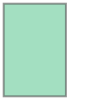

In [ ]:
HFA_poly3

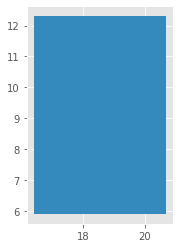

In [ ]:
 p = gpd.GeoSeries(HFA_poly3)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient', 'Location', 'from', 'to', 'xlocation', 'ylocation']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframeusing the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
HFA_poly3_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(HFA_poly3))

In [ ]:
HFA_poly3_gdf

,geometry
0,"POLYGON ((16.40000 12.30000, 16.40000 5.90000,..."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
HFA_join = gpd.sjoin(gdf, HFA_poly3_gdf, how = 'inner')
HFA_join

,Patient,Location,from,to,xlocation,ylocation,geometry,index_right
32,G2341,"17.305,9.603",07/03/2022 10:53,07/03/2022 10:53,17.305,9.603,POINT (17.30500 9.60300),0
33,G2341,"17.892,9.193",07/03/2022 10:53,07/03/2022 10:53,17.892,9.193,POINT (17.89200 9.19300),0
34,G2341,"18.768,9.839",07/03/2022 10:53,07/03/2022 10:53,18.768,9.839,POINT (18.76800 9.83900),0
35,G2341,"18.292,9.193",07/03/2022 10:53,07/03/2022 10:55,18.292,9.193,POINT (18.29200 9.19300),0
36,G2341,"18.292,11.328",07/03/2022 10:55,07/03/2022 10:56,18.292,11.328,POINT (18.29200 11.32800),0
...,...,...,...,...,...,...,...,...
16216,R2409,"17.775,10.687",09/03/2022 15:45,09/03/2022 15:45,17.775,10.687,POINT (17.77500 10.68700),0
16217,R2409,"18.292,9.193",09/03/2022 15:45,09/03/2022 15:55,18.292,9.193,POINT (18.29200 9.19300),0
16218,R2409,"17.121,9.07",09/03/2022 15:55,09/03/2022 15:56,17.121,9.07,POINT (17.12100 9.07000),0
16219,R2409,"17.892,9.193",09/03/2022 15:56,09/03/2022 15:56,17.892,9.193,POINT (17.89200 9.19300),0


## More data cleaning

## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
HFA_join['newfrom'] = lookup(HFA_join['from'], format='%d/%m/%Y %H:%M')
HFA_join['newto'] = lookup(HFA_join['to'], format='%d/%m/%Y %H:%M')

In [ ]:
dfgrouped = HFA_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G2341,2022-03-07 10:53:00,2022-03-07 11:25:00
1,G2342,2022-03-07 10:42:00,2022-03-07 11:02:00
2,G2343,2022-03-07 10:59:00,2022-03-07 11:42:00
3,G2344,2022-03-07 11:09:00,2022-03-07 11:25:00
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00
6,G2348,2022-03-07 11:43:00,2022-03-07 11:54:00
7,G2349,2022-03-07 11:59:00,2022-03-07 12:18:00
8,G2350,2022-03-07 12:04:00,2022-03-07 12:21:00
9,G2351,2022-03-07 11:53:00,2022-03-07 12:08:00


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 01:30:00')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G2341,2022-03-07 10:53:00,2022-03-07 11:25:00,0 days 00:32:00,7,7,equal
1,G2342,2022-03-07 10:42:00,2022-03-07 11:02:00,0 days 00:20:00,7,7,equal
2,G2343,2022-03-07 10:59:00,2022-03-07 11:42:00,0 days 00:43:00,7,7,equal
3,G2344,2022-03-07 11:09:00,2022-03-07 11:25:00,0 days 00:16:00,7,7,equal
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal
6,G2348,2022-03-07 11:43:00,2022-03-07 11:54:00,0 days 00:11:00,7,7,equal
7,G2349,2022-03-07 11:59:00,2022-03-07 12:18:00,0 days 00:19:00,7,7,equal
8,G2350,2022-03-07 12:04:00,2022-03-07 12:21:00,0 days 00:17:00,7,7,equal
9,G2351,2022-03-07 11:53:00,2022-03-07 12:08:00,0 days 00:15:00,7,7,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 01:30:00')

In [ ]:
dfgrouped['visit_length'].describe()

count                          115
mean     0 days 00:23:08.869565217
std      0 days 00:14:58.814780226
min                0 days 00:00:00
25%                0 days 00:15:00
50%                0 days 00:19:00
75%                0 days 00:30:00
max                0 days 01:30:00
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G2341,2022-03-07 10:53:00,2022-03-07 11:25:00,0 days 00:32:00,7,7,equal,Monday
1,G2342,2022-03-07 10:42:00,2022-03-07 11:02:00,0 days 00:20:00,7,7,equal,Monday
2,G2343,2022-03-07 10:59:00,2022-03-07 11:42:00,0 days 00:43:00,7,7,equal,Monday
3,G2344,2022-03-07 11:09:00,2022-03-07 11:25:00,0 days 00:16:00,7,7,equal,Monday
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal,Monday
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal,Monday
6,G2348,2022-03-07 11:43:00,2022-03-07 11:54:00,0 days 00:11:00,7,7,equal,Monday
7,G2349,2022-03-07 11:59:00,2022-03-07 12:18:00,0 days 00:19:00,7,7,equal,Monday
8,G2350,2022-03-07 12:04:00,2022-03-07 12:21:00,0 days 00:17:00,7,7,equal,Monday
9,G2351,2022-03-07 11:53:00,2022-03-07 12:08:00,0 days 00:15:00,7,7,equal,Monday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G2341,2022-03-07 10:53:00,2022-03-07 11:25:00,0 days 00:32:00,7,7,equal,Monday
1,G2342,2022-03-07 10:42:00,2022-03-07 11:02:00,0 days 00:20:00,7,7,equal,Monday
2,G2343,2022-03-07 10:59:00,2022-03-07 11:42:00,0 days 00:43:00,7,7,equal,Monday
3,G2344,2022-03-07 11:09:00,2022-03-07 11:25:00,0 days 00:16:00,7,7,equal,Monday
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal,Monday
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal,Monday
6,G2348,2022-03-07 11:43:00,2022-03-07 11:54:00,0 days 00:11:00,7,7,equal,Monday
7,G2349,2022-03-07 11:59:00,2022-03-07 12:18:00,0 days 00:19:00,7,7,equal,Monday
8,G2350,2022-03-07 12:04:00,2022-03-07 12:21:00,0 days 00:17:00,7,7,equal,Monday
9,G2351,2022-03-07 11:53:00,2022-03-07 12:08:00,0 days 00:15:00,7,7,equal,Monday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon      0 days 00:26:02.500000
morning     0 days 00:21:04.477611940
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:28:46.666666666
Tuesday,0 days 00:27:12.500000
Wednesday,0 days 00:21:42
Thursday,0 days 00:18:00
Friday,0 days 00:18:15.652173913
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
27
Tuesday
24
Wednesday
20
Thursday
21
Friday
23
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G2341,2022-03-07 10:53:00,2022-03-07 11:25:00,0 days 00:32:00,7,7,equal,Monday,morning,10
1,G2342,2022-03-07 10:42:00,2022-03-07 11:02:00,0 days 00:20:00,7,7,equal,Monday,morning,10
2,G2343,2022-03-07 10:59:00,2022-03-07 11:42:00,0 days 00:43:00,7,7,equal,Monday,morning,10
3,G2344,2022-03-07 11:09:00,2022-03-07 11:25:00,0 days 00:16:00,7,7,equal,Monday,morning,11
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal,Monday,morning,10
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal,Monday,morning,10
6,G2348,2022-03-07 11:43:00,2022-03-07 11:54:00,0 days 00:11:00,7,7,equal,Monday,morning,11
7,G2349,2022-03-07 11:59:00,2022-03-07 12:18:00,0 days 00:19:00,7,7,equal,Monday,morning,11
8,G2350,2022-03-07 12:04:00,2022-03-07 12:21:00,0 days 00:17:00,7,7,equal,Monday,morning,12
9,G2351,2022-03-07 11:53:00,2022-03-07 12:08:00,0 days 00:15:00,7,7,equal,Monday,morning,11


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10             0 days 00:25:42
11   0 days 00:18:05.217391304
12   0 days 00:17:42.352941176
13   0 days 00:25:51.428571428
14             0 days 00:29:45
15   0 days 00:23:11.428571428
16             0 days 00:16:20
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
20
Eleven
23
Twelve
17
One
7
Two
24
Three
21
Four
3


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:25:12.815533980
R             0 days 00:05:25
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
103
Medical Retinal
12


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 10:53:00,2022-03-07 11:25:00,0 days 00:32:00,7,7,equal,Monday,morning,10,G,32.0000
1,G2342,2022-03-07 10:42:00,2022-03-07 11:02:00,0 days 00:20:00,7,7,equal,Monday,morning,10,G,20.0000
2,G2343,2022-03-07 10:59:00,2022-03-07 11:42:00,0 days 00:43:00,7,7,equal,Monday,morning,10,G,43.0000
3,G2344,2022-03-07 11:09:00,2022-03-07 11:25:00,0 days 00:16:00,7,7,equal,Monday,morning,11,G,16.0000
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal,Monday,morning,10,G,55.0000
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal,Monday,morning,10,G,60.0000
6,G2348,2022-03-07 11:43:00,2022-03-07 11:54:00,0 days 00:11:00,7,7,equal,Monday,morning,11,G,11.0000
7,G2349,2022-03-07 11:59:00,2022-03-07 12:18:00,0 days 00:19:00,7,7,equal,Monday,morning,11,G,19.0000
8,G2350,2022-03-07 12:04:00,2022-03-07 12:21:00,0 days 00:17:00,7,7,equal,Monday,morning,12,G,17.0000
9,G2351,2022-03-07 11:53:00,2022-03-07 12:08:00,0 days 00:15:00,7,7,equal,Monday,morning,11,G,15.0000


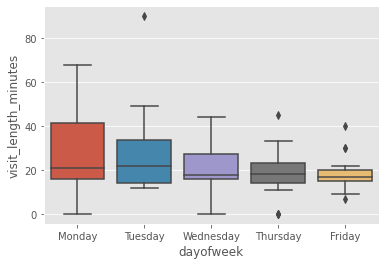

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

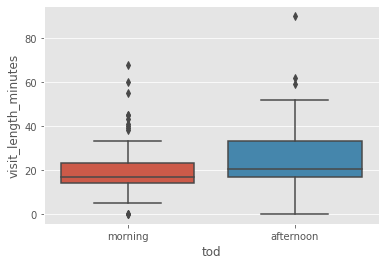

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

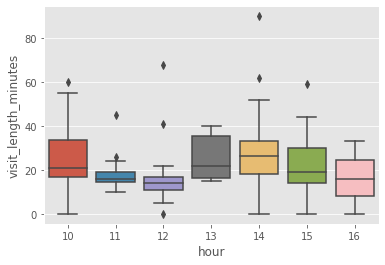

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

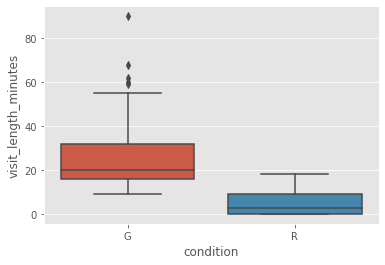

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 10
newfrom                 10
newto                   10
visit_length            10
start_day               10
end_day                 10
sameday                 10
dayofweek               10
tod                     10
hour                    10
condition               10
visit_length_minutes    10
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 10:53:00,2022-03-07 11:25:00,0 days 00:32:00,7,7,equal,Monday,morning,10,G,32.0000
1,G2342,2022-03-07 10:42:00,2022-03-07 11:02:00,0 days 00:20:00,7,7,equal,Monday,morning,10,G,20.0000
2,G2343,2022-03-07 10:59:00,2022-03-07 11:42:00,0 days 00:43:00,7,7,equal,Monday,morning,10,G,43.0000
3,G2344,2022-03-07 11:09:00,2022-03-07 11:25:00,0 days 00:16:00,7,7,equal,Monday,morning,11,G,16.0000
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal,Monday,morning,10,G,55.0000
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal,Monday,morning,10,G,60.0000
6,G2348,2022-03-07 11:43:00,2022-03-07 11:54:00,0 days 00:11:00,7,7,equal,Monday,morning,11,G,11.0000
7,G2349,2022-03-07 11:59:00,2022-03-07 12:18:00,0 days 00:19:00,7,7,equal,Monday,morning,11,G,19.0000
8,G2350,2022-03-07 12:04:00,2022-03-07 12:21:00,0 days 00:17:00,7,7,equal,Monday,morning,12,G,17.0000
9,G2351,2022-03-07 11:53:00,2022-03-07 12:08:00,0 days 00:15:00,7,7,equal,Monday,morning,11,G,15.0000


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

22.15929203539823
23.401869158878505


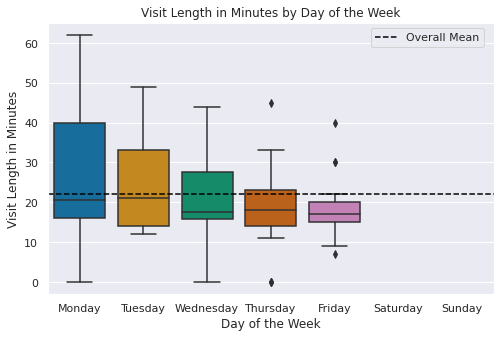

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

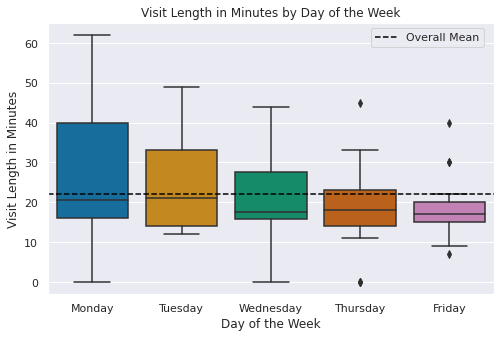

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

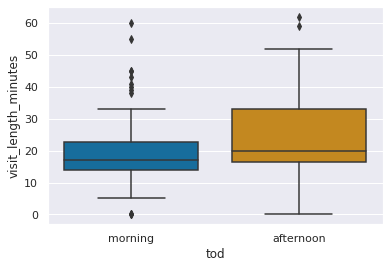

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

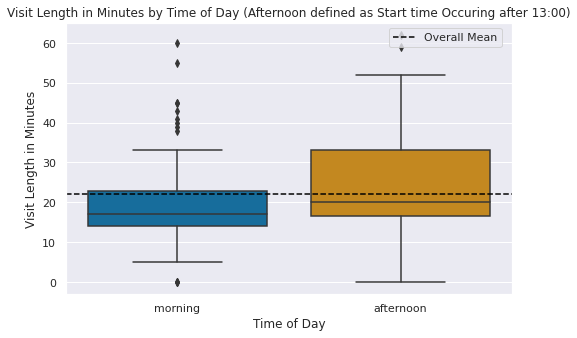

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

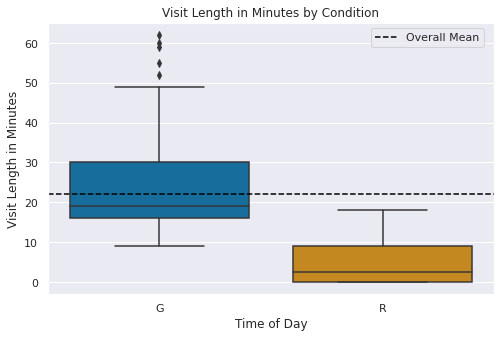

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

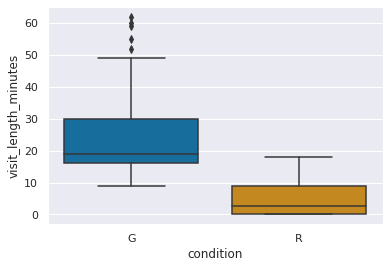

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

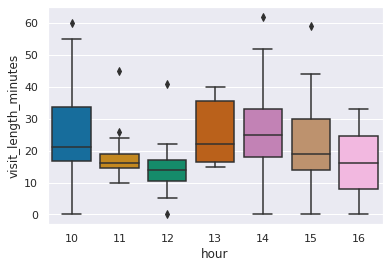

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

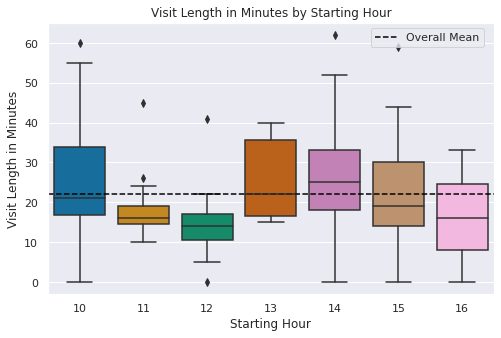

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   113.0000
mean                                     22.1593
std                                      13.0217
min                                       0.0000
25%                                      15.0000
50%                                      18.0000
75%                                      29.0000
max                                      62.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                   115.0000
mean                                     23.1478
std                                      14.9802
min                                       0.0000
25%                                      15.0000
50%                                      19.0000
75%                                      30.0000
max                                      90.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

19.0

In [ ]:
df_outliers['visit_length'].describe()

count                          113
mean     0 days 00:22:09.557522123
std      0 days 00:13:01.299729137
min                0 days 00:00:00
25%                0 days 00:15:00
50%                0 days 00:18:00
75%                0 days 00:29:00
max                0 days 01:02:00
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                          115
mean     0 days 00:23:08.869565217
std      0 days 00:14:58.814780226
min                0 days 00:00:00
25%                0 days 00:15:00
50%                0 days 00:19:00
75%                0 days 00:30:00
max                0 days 01:30:00
Name: visit_length, dtype: object

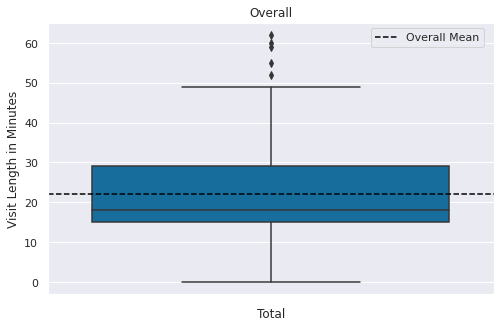

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
20
Eleven
23
Twelve
16
One
7
Two
23
Three
21
Four
3


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
26
Tuesday Outlier
23
Wednesday Outlier
20
Thursday Outlier
21
Friday Outlier
23
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                       27.2692
Tuesday                                      24.4783
Wednesday                                    21.7000
Thursday                                     18.0000
Friday                                       18.2609
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
101
R
12


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                    24.1485
R                                     5.4167
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
66
afternoon
47


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                    24.6809
morning                                      20.3636
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
20
Eleven
23
Twelve
16
One
7
Two
23
Three
21
Four
3


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                    25.7000
11                                    18.0870
12                                    14.5625
13                                    25.8571
14                                    27.1304
15                                    23.1905
16                                    16.3333
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 10
newfrom                 10
newto                   10
visit_length            10
start_day               10
end_day                 10
sameday                 10
dayofweek               10
tod                     10
hour                    10
condition               10
visit_length_minutes    10
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 6
newfrom                 6
newto                   6
visit_length            6
start_day               6
end_day                 6
sameday                 6
dayofweek               6
tod                     6
hour                    6
condition               6
visit_length_minutes    6
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 107
newfrom                 107
newto                   107
visit_length            107
start_day               107
end_day                 107
sameday                 107
dayofweek               107
tod                     107
hour                    107
condition               107
visit_length_minutes    107
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
103,R1536,2022-03-07 10:52:00,2022-03-07 10:52:00,0 days,7,7,equal,Monday,morning,10,R,0.0000
106,R1551,2022-03-07 15:39:00,2022-03-07 15:39:00,0 days,7,7,equal,Monday,afternoon,15,R,0.0000
107,R1572,2022-03-09 10:52:00,2022-03-09 10:52:00,0 days,9,9,equal,Wednesday,morning,10,R,0.0000
108,R1594,2022-03-10 12:18:00,2022-03-10 12:18:00,0 days,10,10,equal,Thursday,morning,12,R,0.0000
109,R1597,2022-03-10 14:40:00,2022-03-10 14:40:00,0 days,10,10,equal,Thursday,afternoon,14,R,0.0000


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
103,R1536,2022-03-07 10:52:00,2022-03-07 10:52:00,0 days,7,7,equal,Monday,morning,10,R,0.0000
106,R1551,2022-03-07 15:39:00,2022-03-07 15:39:00,0 days,7,7,equal,Monday,afternoon,15,R,0.0000
107,R1572,2022-03-09 10:52:00,2022-03-09 10:52:00,0 days,9,9,equal,Wednesday,morning,10,R,0.0000
108,R1594,2022-03-10 12:18:00,2022-03-10 12:18:00,0 days,10,10,equal,Thursday,morning,12,R,0.0000
109,R1597,2022-03-10 14:40:00,2022-03-10 14:40:00,0 days,10,10,equal,Thursday,afternoon,14,R,0.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
17,G2359,2022-03-07 14:38:00,2022-03-07 15:40:00,0 days 01:02:00,7,7,equal,Monday,afternoon,14,G,62.0000
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal,Monday,morning,10,G,60.0000
21,G2363,2022-03-07 15:21:00,2022-03-07 16:20:00,0 days 00:59:00,7,7,equal,Monday,afternoon,15,G,59.0000
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal,Monday,morning,10,G,55.0000
18,G2360,2022-03-07 14:52:00,2022-03-07 15:44:00,0 days 00:52:00,7,7,equal,Monday,afternoon,14,G,52.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
17,G2359,2022-03-07 14:38:00,2022-03-07 15:40:00,0 days 01:02:00,7,7,equal,Monday,afternoon,14,G,62.0000
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal,Monday,morning,10,G,60.0000
21,G2363,2022-03-07 15:21:00,2022-03-07 16:20:00,0 days 00:59:00,7,7,equal,Monday,afternoon,15,G,59.0000
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal,Monday,morning,10,G,55.0000
18,G2360,2022-03-07 14:52:00,2022-03-07 15:44:00,0 days 00:52:00,7,7,equal,Monday,afternoon,14,G,52.0000


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
41,G2384,2022-03-08 14:50:00,2022-03-08 16:20:00,0 days 01:30:00,8,8,equal,Tuesday,afternoon,14,G,90.0000
12,G2354,2022-03-07 12:47:00,2022-03-07 13:55:00,0 days 01:08:00,7,7,equal,Monday,morning,12,G,68.0000
17,G2359,2022-03-07 14:38:00,2022-03-07 15:40:00,0 days 01:02:00,7,7,equal,Monday,afternoon,14,G,62.0000
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal,Monday,morning,10,G,60.0000
21,G2363,2022-03-07 15:21:00,2022-03-07 16:20:00,0 days 00:59:00,7,7,equal,Monday,afternoon,15,G,59.0000
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal,Monday,morning,10,G,55.0000
18,G2360,2022-03-07 14:52:00,2022-03-07 15:44:00,0 days 00:52:00,7,7,equal,Monday,afternoon,14,G,52.0000
38,G2381,2022-03-08 14:42:00,2022-03-08 15:31:00,0 days 00:49:00,8,8,equal,Tuesday,afternoon,14,G,49.0000
25,G2367,2022-03-08 10:53:00,2022-03-08 11:38:00,0 days 00:45:00,8,8,equal,Tuesday,morning,10,G,45.0000
72,G2418,2022-03-10 11:26:00,2022-03-10 12:11:00,0 days 00:45:00,10,10,equal,Thursday,morning,11,G,45.0000


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
17,G2359,2022-03-07 14:38:00,2022-03-07 15:40:00,0 days 01:02:00,7,7,equal,Monday,afternoon,14,G,62.0000
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal,Monday,morning,10,G,60.0000
21,G2363,2022-03-07 15:21:00,2022-03-07 16:20:00,0 days 00:59:00,7,7,equal,Monday,afternoon,15,G,59.0000
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal,Monday,morning,10,G,55.0000
18,G2360,2022-03-07 14:52:00,2022-03-07 15:44:00,0 days 00:52:00,7,7,equal,Monday,afternoon,14,G,52.0000
38,G2381,2022-03-08 14:42:00,2022-03-08 15:31:00,0 days 00:49:00,8,8,equal,Tuesday,afternoon,14,G,49.0000
25,G2367,2022-03-08 10:53:00,2022-03-08 11:38:00,0 days 00:45:00,8,8,equal,Tuesday,morning,10,G,45.0000
72,G2418,2022-03-10 11:26:00,2022-03-10 12:11:00,0 days 00:45:00,10,10,equal,Thursday,morning,11,G,45.0000
64,G2408,2022-03-09 15:10:00,2022-03-09 15:54:00,0 days 00:44:00,9,9,equal,Wednesday,afternoon,15,G,44.0000
2,G2343,2022-03-07 10:59:00,2022-03-07 11:42:00,0 days 00:43:00,7,7,equal,Monday,morning,10,G,43.0000


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 10:53:00,2022-03-07 11:25:00,0 days 00:32:00,7,7,equal,Monday,morning,10,G,32.0000
1,G2342,2022-03-07 10:42:00,2022-03-07 11:02:00,0 days 00:20:00,7,7,equal,Monday,morning,10,G,20.0000
2,G2343,2022-03-07 10:59:00,2022-03-07 11:42:00,0 days 00:43:00,7,7,equal,Monday,morning,10,G,43.0000
3,G2344,2022-03-07 11:09:00,2022-03-07 11:25:00,0 days 00:16:00,7,7,equal,Monday,morning,11,G,16.0000
4,G2345,2022-03-07 10:55:00,2022-03-07 11:50:00,0 days 00:55:00,7,7,equal,Monday,morning,10,G,55.0000
5,G2346,2022-03-07 10:55:00,2022-03-07 11:55:00,0 days 01:00:00,7,7,equal,Monday,morning,10,G,60.0000
6,G2348,2022-03-07 11:43:00,2022-03-07 11:54:00,0 days 00:11:00,7,7,equal,Monday,morning,11,G,11.0000
7,G2349,2022-03-07 11:59:00,2022-03-07 12:18:00,0 days 00:19:00,7,7,equal,Monday,morning,11,G,19.0000
8,G2350,2022-03-07 12:04:00,2022-03-07 12:21:00,0 days 00:17:00,7,7,equal,Monday,morning,12,G,17.0000
9,G2351,2022-03-07 11:53:00,2022-03-07 12:08:00,0 days 00:15:00,7,7,equal,Monday,morning,11,G,15.0000


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']


,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes


## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
df_outliers['clinic_location'] = 'HFA'
HFAdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()
HFAdf.to_csv('HFAdf_phase3.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
